In [48]:
#lib(s)
import keras
from keras.datasets import mnist
from keras.layers import *
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [49]:
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [50]:
#loading mnist dataset
(X_train, y_train),(X_test,y_test)=mnist.load_data()

In [51]:
y_train.shape

(60000,)

In [52]:
X_train.shape

(60000, 28, 28)

In [53]:
X_test.shape

(10000, 28, 28)

In [54]:
#to use 60000 of training dataset + 10000 of testing dataset
X_train=np.concatenate((X_train,X_test))
y_train=np.concatenate((y_train,y_test))

In [55]:
X_train.shape

(70000, 28, 28)

In [57]:
#to take only 9 and 8 values' dataset
x=[]
for i in range(len(y_train)):
  if y_train[i]==9 or y_train[i]==8:
    x.append(X_train[i])

In [58]:
#convert into array
X_train=np.array(x)

In [59]:
#final shape
X_train.shape

(13783, 28, 28)

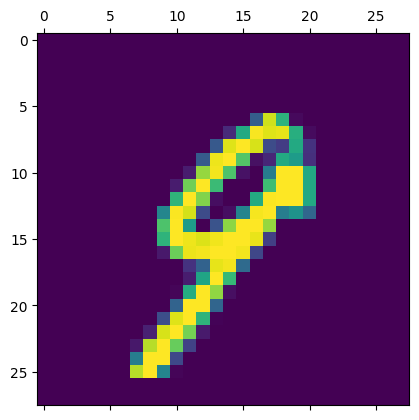

In [60]:
plt.matshow(X_train[202])

In [61]:
#to convert [0,255] values from range -1 to 1....normalization
X_train=(X_train-127.5)/127.5

In [62]:
print(X_train.min())
print(X_train.max())

-1.0
1.0


In [63]:
X_train[0][0]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1.])

In [64]:
TOTAL_EPOCHS= 50
BATCH_SIZE=256   #in 1 go 256 images
HALF_BATCH=128   #half of batch size

NO_OF_BATCHES= int(X_train.shape[0]/BATCH_SIZE)     #60000/256
print(NO_OF_BATCHES)

53


In [65]:
NOISE_DIM=100

#changing the learning rate of adam
adam=Adam(lr=2e-4,beta_1=0.5)

In [66]:
#GENERATOR MODEL : Upsampling

generator=Sequential()
generator.add(Dense(units=7*7*128,input_shape=(NOISE_DIM,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())    #to prevent overfitting .... it is used for normalization between layers

#(7,7,128) -> (14,14, 64)
#padding = same... means to add additional rows and columns of pixels around the edges basicially add 0's
#its is done so to increase the side of the output feature map same as the size of input data size
#Conv2DTranspose is used for upsampling
generator.add(Conv2DTranspose(64,(3,3),strides=(2,2),padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())


#(14,14,64) -> (28,28, 1)
generator.add(Conv2DTranspose(1,(3,3),strides=(2,2),padding='same',activation='tanh'))



In [67]:
generator.compile(loss=keras.losses.binary_crossentropy, optimizer= adam)

In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 43.4 MB/s eta 0:00:00


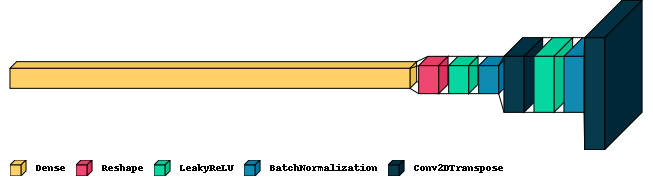

In [ ]:
import visualkeras
visualkeras.layered_view(generator,legend=True)

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       73792     
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0

In [68]:
#Discriminator model : Downsampling

# (28,28, 1)->(14,14,64)
discriminator=Sequential()
discriminator.add(Conv2D(64,kernel_size=(3,3),strides=(2,2),padding='same',input_shape=(28,28,1)))
discriminator.add(LeakyReLU(0.2))
# (14,14,64)->(7,7,128)
discriminator.add(Conv2D(128,kernel_size=(3,3),strides=(2,2),padding='same'))
discriminator.add(LeakyReLU(0.2))
# (7,7,128)->6272
discriminator.add(Flatten())
discriminator.add(Dense(100))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Dense(1,activation='sigmoid'))


In [69]:
discriminator.compile(loss=keras.losses.binary_crossentropy,optimizer=adam)

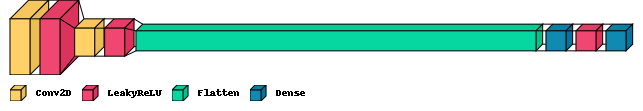

In [ ]:
visualkeras.layered_view(discriminator,legend=True)

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 100)               627300    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 100)              

In [70]:
#Combined model

discriminator.trainable=True

#name of the model
gan_input=Input(shape=(NOISE_DIM,))

generated_img=generator(gan_input)

gan_output= discriminator(generated_img)

#Functional API

model= Model(gan_input,gan_output)

model.compile(loss=keras.losses.binary_crossentropy, optimizer=adam)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         708609    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 701897    
                                                                 
Total params: 1,410,506
Trainable params: 1,410,122
Non-trainable params: 384
_________________________________________________________________


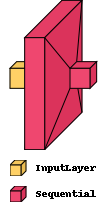

In [ ]:
visualkeras.layered_view(model,legend=True)

In [71]:
X_train=X_train.reshape(-1,28,28,1)
X_train.shape

(13783, 28, 28, 1)

In [72]:
#display the images can be generated by gene
def display_images(samples=25):
  noise = np.random.normal(0,1,size=(samples, NOISE_DIM))
  generated_img=generator.predict(noise)
  plt.figure(figsize=(10,10))
  for i in range(samples):
    plt.subplot(5,5,i+1)
    plt.imshow(generated_img[i].reshape(28,28), cmap='binary')
    plt.axis('off')
  plt.show()

Epoch 1, Discriminator loss 0.166573696914744, Generator loss 0.00081684625815196
Epoch 2, Discriminator loss 0.16446333721868764, Generator loss 0.0006077423689553057
Epoch 3, Discriminator loss 0.16457430021409034, Generator loss 0.0006243209964112502
Epoch 4, Discriminator loss 0.2299231566315218, Generator loss 0.14330468732283785
Epoch 5, Discriminator loss 0.4721319812508124, Generator loss 0.38796350029560756
Epoch 6, Discriminator loss 0.5889089453332829, Generator loss 0.606171651831213
Epoch 7, Discriminator loss 0.5603839071854105, Generator loss 0.6861310286341973
Epoch 8, Discriminator loss 0.5470888541554505, Generator loss 0.7138855625998299
Epoch 9, Discriminator loss 0.5450429677400949, Generator loss 0.7181164554829867
Epoch 10, Discriminator loss 0.5516742172668565, Generator loss 0.7163046992050027
1/1 [==============================] - 0s 99ms/step


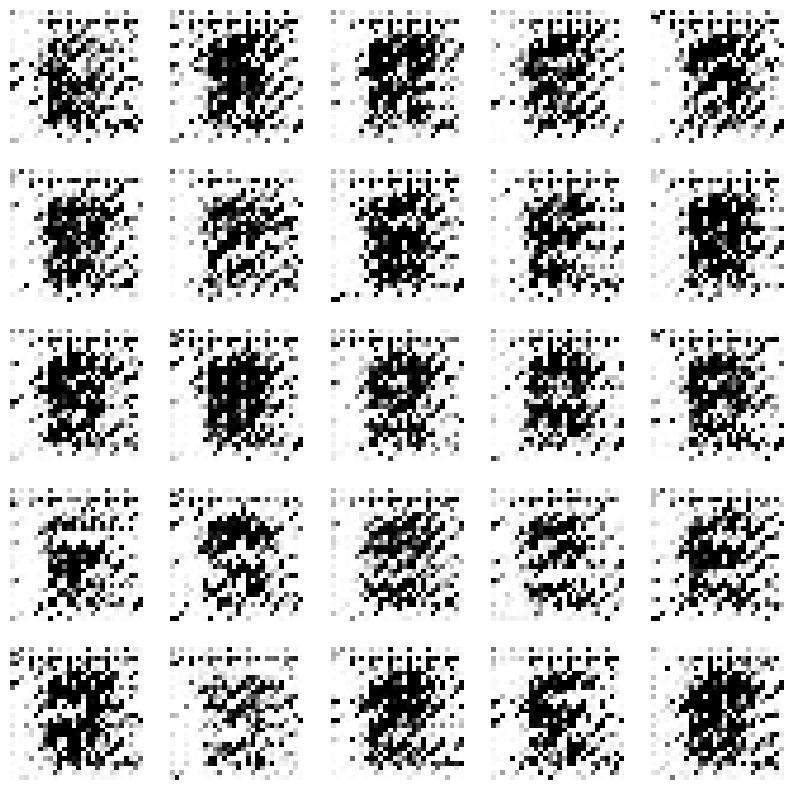

In [74]:
#Training loop

d_losses=[]
g_losses=[]

for epoch in range(10):
  epoch_d_loss=0.0
  epoch_g_loss=0.0

  #Mini batch gradient decent

  for step in range(NO_OF_BATCHES):

    #STEP 1 Train Discriminator
    discriminator.trainable=True


    #get the real data
    idx=np.random.randint(0,13783,HALF_BATCH)  #range 0 to 60000 in array of size HALF_BATCH
    real_imgs=X_train[idx]

    #get the fake data
    noise=np.random.normal(0,1,size=(HALF_BATCH,NOISE_DIM))    #128 rows    individual row 100 data .... as normal thereform [-1,1]
    fake_imgs=generator.predict(noise,verbose=0)

    #Labels
    real_y = np.ones((HALF_BATCH,1))*0.9
    fake_y = np.zeros((HALF_BATCH,1))


    #Now, train D

    d_loss_real= discriminator.train_on_batch(real_imgs,real_y)
    d_loss_fake= discriminator.train_on_batch(fake_imgs,fake_y)


    d_loss=0.5*d_loss_real+0.5*d_loss_fake
    epoch_d_loss+=d_loss



    #STEP 2 Train Generator
    discriminator.trainable=False

    noise=np.random.normal(0,1,size=(BATCH_SIZE,NOISE_DIM))
    ground_truth_y=np.ones((BATCH_SIZE,1))

    g_loss=model.train_on_batch(noise,ground_truth_y)
    epoch_g_loss+=g_loss


    ###################

    d_losses.append(epoch_d_loss/NO_OF_BATCHES)
    g_losses.append(epoch_g_loss/NO_OF_BATCHES)
  print(f'Epoch {epoch+1}, Discriminator loss {epoch_d_loss/NO_OF_BATCHES}, Generator loss {epoch_g_loss/NO_OF_BATCHES}')


  if (epoch+1) % 10 == 0:
    #generator.save("generator.h5")
    display_images()

In [36]:
#generator.save("generator_9_8.h5")

In [2]:
from tensorflow.keras.models import load_model

In [3]:
model=load_model(r'C:\Users\Lenovo\Downloads\generator_9_8.h5')

2/2 [==============================] - 0s 8ms/step


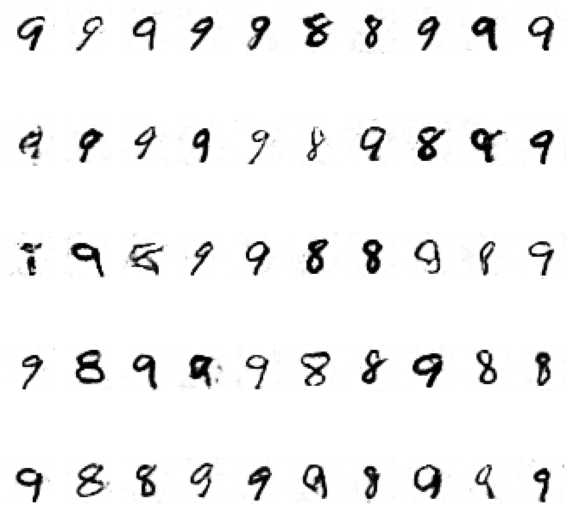

In [7]:
#AFTER 200 epochs
#import numpy as np
#NOISE_DIM=100
#import matplotlib.pyplot as plt
noise = np.random.normal(0,1,size=(50, NOISE_DIM))
generated_img=model.predict(noise)
plt.figure(figsize=(10,10))
for i in range(50):
  plt.subplot(5,10,i+1)
  plt.imshow(generated_img[i].reshape(28,28), cmap='binary')
  plt.axis('off')
plt.show()